# Quandl And Futures Options

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns



We are likely to run this notebook over and over, so we add memoizaiton to the data loading function. This makes testing and re-running our code far faster, and even lets us work offline.  Note that if we change the code inside our function, we may get unexpectedly stale results out of the cache!

In [3]:
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas", 
                      trim_start=trim_start, trim_end=trim_end,
                      api_key=BrianBoonstraPrivateKeys['Quandl'])
    return qdata

In [4]:
emini_contracts = 'OWF/CME_ES_ES_X2014_IVM'

In [5]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

In [6]:
es_option_data = clean_quandl_columns(fetch_quandl((emini_contracts,),
                                                   trim_start="2014-10-01", 
                                                   trim_end="2014-10-31")
                                     )

In [7]:
es_option_data.iloc[0]

Future      1940.800000
AtM            0.148062
RR25          -0.060531
RR10          -0.115090
Fly25          0.003127
Fly10          0.015248
Beta1         -0.840082
Beta2         -1.490824
Beta3         14.031784
Beta4        314.503509
Beta5       1916.009974
Beta6       3868.545066
MinMoney      -0.199366
MaxMoney       0.071669
DtE           51.000000
DtT           79.000000
Name: 2014-10-01 00:00:00, dtype: float64

In [14]:
ends = pd.concat((es_option_data.head(3),es_option_data.tail(3)))
ends[ends.columns[::-1]]

,DtT,DtE,MaxMoney,MinMoney,Beta6,Beta5,Beta4,Beta3,Beta2,Beta1,Fly10,Fly25,RR10,RR25,AtM,Future
Date,,,,,,,,,,,,,,,,
2014-10-01,79.0,51.0,0.071669,-0.199366,3868.545066,1916.009974,314.503509,14.031784,-1.490824,-0.840082,0.015248,0.003127,-0.115090,-0.060531,0.148062,1940.8
2014-10-02,78.0,50.0,0.070402,-0.191962,5886.276284,2652.342734,386.061630,13.533725,-1.577831,-0.815366,0.014360,0.002756,-0.107791,-0.056233,0.142854,1938.6
2014-10-03,77.0,49.0,0.061671,-0.172322,7192.740693,3466.762303,553.561776,23.579962,-1.881750,-0.845787,0.012711,0.002622,-0.098670,-0.052449,0.130725,1960.3
2014-10-29,51.0,23.0,0.050811,-0.119534,62521.663885,18617.779525,1881.222489,68.808967,-0.407017,-1.076650,0.015920,0.003588,-0.092584,-0.047319,0.131450,1972.2
2014-10-30,50.0,22.0,0.049733,-0.116451,-6790.819555,4474.002299,1431.359164,118.411261,2.307366,-1.068422,0.016459,0.004276,-0.085519,-0.044523,0.127087,1988.6
2014-10-31,49.0,21.0,0.050224,-0.108270,-10629.874508,5085.933217,1506.250593,111.790780,3.293582,-0.916532,0.014891,0.003589,-0.070865,-0.036375,0.123652,2011.4


### The OptionWorks Volatility Parameterization

OptionWork parameterizes volatility as a funciton of moneyness with a degree 6 polynomial.  This is unstable outside the fitted range.

In [15]:
def vols(r):
    moneyness = pd.Series(np.linspace(start=r.MinMoney, stop=r.MaxMoney, num=100))
    vola = r.AtM + (r.Beta1*moneyness + r.Beta2*moneyness**2 + r.Beta3*moneyness**3
                     + r.Beta4*moneyness**4 + r.Beta5*moneyness**5 + r.Beta6*moneyness**6)
    vola.name="ImplVol"
    future = r.Future * np.exp(moneyness)
    return pd.DataFrame({"Dec Emini Future": future, "Moneyness": moneyness, "ImplVol": vola})


We see a typical skew.

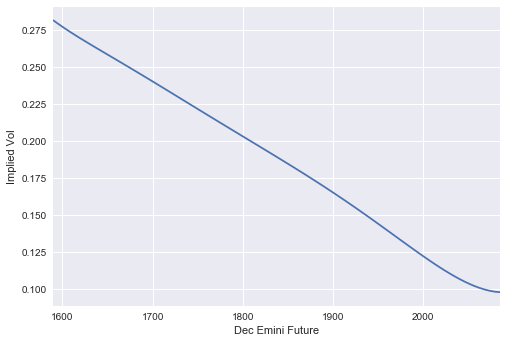

In [16]:
v = vols(es_option_data.iloc[0])
ax = v.plot(x="Dec Emini Future", y="ImplVol", legend=False)
_ = ax.set_ylabel("Implied Vol")